In [11]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# PARAMS
HBAR        = 1.0
MASS        = 1.0
PBC         = True
N_PARTICLES = 2
N_POINTS    = 100

# Two particles

### Exact Diagonalization

The one body part (kinetic and potential terms) of the hamiltonian in the position basis reads:

$$H = \mathbb{I}\otimes \dots \otimes K_i\otimes \mathbb{I}\otimes ...\otimes \mathbb{I}+\mathbb{I}\otimes \dots \otimes V_i\otimes \mathbb{I}\otimes ...\otimes \mathbb{I}$$

Where $K_i \equiv -\frac{\hbar^2}{2m}\nabla_i^2,\quad V_i \equiv V(x_i)$ and $i$ is the index of the particle.

How to construct the hamiltonian: Given a base (in this case distretized positions) $\ket{x_1 x_2...x_p}$ with $p$ particles

$$\hat H = \sum_{i,j,...}\sum_{ i', j', ...}\bra{x_i x_j...}\hat{H}\ket{x_{i'} x_{j'}...}\ket{x_i x_j...}\bra{x_{i'} x_{j'}...}$$

Where $\hat{H} = \sum_{i=1}^P T_i+V_i + \sum_{i<j}U(x_i-y_j)$

With two particles, the matrix elements $\bra{x_i y_j}\hat{H}\ket{x_i y_j}$ are:

$$\bra{x_i y_j}\hat{H}\ket{x_i y_j} = \bra{x_i}T+V\ket{x_j} + \braket{y}$$

$$\hat{H} = \sum_{i_1=1}^N \cdots \sum_{i_P=1}^N \sum_{j_1=1}^N \cdots \sum_{j_P=1}^N
\langle x_{i_1} x_{i_2} \dots x_{i_P} | \hat{H} | x_{j_1} x_{j_2} \dots x_{j_P} \rangle
\, | x_{i_1} x_{i_2} \dots x_{i_P} \rangle \langle x_{j_1} x_{j_2} \dots x_{j_P} |$$


$$\hat{H} = \sum_{i_1\cdots i_P=1}^N \sum_{j_1\cdots j_P=1}^N
\langle x_{i_1} x_{i_2} \dots x_{i_P} | \hat{H} | x_{j_1} x_{j_2} \dots x_{j_P} \rangle
\, | x_{i_1} x_{i_2} \dots x_{i_P} \rangle \langle x_{j_1} x_{j_2} \dots x_{j_P} |$$

For 2 particles we have:

$$\hat{H} = \sum_{i_1 i_2 = 1}^2\sum_{j_1 j_2 = 1}^2\langle x_{i_1} x_{i_2} | \hat{H} | x_{j_1} x_{j_2} \rangle
\, | x_{i_1} x_{i_2}\rangle \langle x_{j_1} x_{j_2} |$$

Where

$$\langle x_{i_1} x_{i_2} | \hat{H} | x_{j_1} x_{j_2} \rangle = \langle x_{i_1} x_{i_2} | T_1+V_1+T_2+V_2+\sum_{i<j}U_{ij} | x_{j_1} x_{j_2} \rangle = $$

$$= \langle x_{i_1} | T_1+V_1\ket{x_{j_1}}\langle{x_{i_2}}|{x_{j_2}}\rangle+\langle x_{i_2} | T_2+V_2\ket{x_{j_2}}\langle{x_{i_1}}|{x_{j_1}}\rangle+\sum_{i<j} \langle x_{i_1} x_{i_2} |U_{ij}| x_{j_1} x_{j_2} \rangle$$

Using that in position space, the potentials are diagonal: $\langle y| V | x\rangle = V(x)\delta_{xy}$

$$= \langle x_{i_1} | T_1+V_1\ket{x_{j_1}}\delta_{{x_{i_2}}{x_{j_2}}}+\langle x_{i_2} | T_2+V_2\ket{x_{j_2}}\delta_{{x_{i_1}}x_{j_1}}+\sum_{i<j}U(x_{j_1} x_{j_2})$$

In [13]:
def identity(NGrid):
    """Create the identity operator for N particles."""
    return torch.eye(NGrid, device=device)

II = identity(N_POINTS)

In [14]:
def single_particle_potential(x,V0,K1):
    return V0*torch.sin(K1*x).pow(2)

In [15]:
def hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC, potential_parameters, x):
    kin_coeff = -HBAR**2 / (2 * MASS * GRID_SPACING**2)
    kin_main_diag = -2*torch.ones(N_POINTS, device=device)  # Main diagonal for kinetic energy
    kin_off_diags = 1*torch.ones(N_POINTS-1, device=device)  # Off-diagonal elements for kinetic energy
    # kin_matrix = torch.zeros((N_POINTS, N_POINTS))
    kin_matrix = torch.diag(kin_main_diag).to(device)
    kin_matrix += torch.diag(kin_off_diags, diagonal=1)
    kin_matrix += torch.diag(kin_off_diags, diagonal=-1)
    if PBC:
        kin_matrix[0, -1] = 1
        kin_matrix[-1, 0] = 1
    pot_matrix = torch.zeros((N_POINTS, N_POINTS), device=device)
    for i in range(N_POINTS):
        pot_matrix[i, i] = single_particle_potential(x[i],**potential_parameters)
        # TO TRY HARMONIC POTENTIAL COMMENT OUT ABOVE LINE AND UNCOMMENT BELOW
        # pot_matrix[i, i] = 0.5*MASS* x[i]**2  # Harmonic potential
    return kin_coeff * kin_matrix + pot_matrix

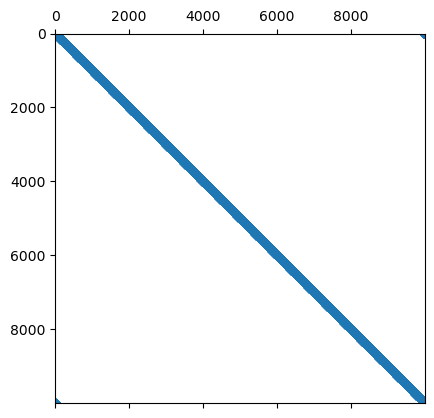

In [21]:
one_body_hami = hamiltonian_matrix(
    N_POINTS=100,
    GRID_SPACING=0.1,
    PBC=PBC,
    potential_parameters={
        'V0': 1.0,
        'K1': 1.0
    },
    x=torch.linspace(0, 10, 100, device=device)
)

full_onebody_hami = torch.kron(II, one_body_hami)+ torch.kron(one_body_hami, II)
# Plotting the Hamiltonian matrix
plt.spy(full_onebody_hami.cpu(), markersize=1)

In [17]:
def interaction_potential(x1, x2, g):
    """Define the interaction potential between two particles."""
    return g * torch.exp(-((x1 - x2) ** 2))

In [18]:
def two_body_hamiltonian()

SyntaxError: expected ':' (3527369108.py, line 1)